In [1]:
import numpy as np
import h5py

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input

import pydot

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import scipy.misc
from matplotlib.pyplot import imshow

%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">

In [2]:
def identity_block(X,f,filters,stage,block):
    
    conv_name_base = 'res' + str(stage) + str(block) + '_branch'
    bn_name_base = 'bn' + str(stage) + str(block) + '_branch'
    
    f1,f2,f3 = filters
    X_shortcut = X
    
    X = Conv2D(filters=f1,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2a')(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=f2,kernel_size=(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b')(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X   

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">

In [3]:
def conv_block(X,f,filters,stage,block,s=2):
    
    conv_namebase = 'res' + str(stage) + block + '_branch'
    bn_namebase = 'bn' + str(stage) + block + '_branch'
    
    f1,f2,f3 = filters
    
    X_shortcut = X
    
    X = Conv2D(f1,(1,1),strides=(s,s),name=conv_namebase+'2a')(X)
    X = BatchNormalization(axis=3,name=bn_namebase+'2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f2,(f,f),strides=(1,1),padding='same',name=conv_namebase+'2b')(X)
    X = BatchNormalization(axis=3,name=bn_namebase+'2b')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f3,(1,1),strides=(1,1),name=conv_namebase+'2c')(X)
    X = BatchNormalization(axis=3,name=bn_namebase+'2c')(X)
    
    X_shortcut = Conv2D(f3,(1,1),strides=(s,s),name=conv_namebase+'1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,name=bn_namebase+'1')(X_shortcut)
    
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X   

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">

In [4]:
def ResNet50(input_shape=(64,64,3),classes=6):
    
    #Input
    X_input = Input(input_shape)
    X = ZeroPadding2D((3,3))(X_input)
    #stage 1
    X = Conv2D(64,(7,7),strides=(2,2),name='conv1')(X)
    X = BatchNormalization(axis=3,name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)
    #stage 2
    X = conv_block(X,f=3,filters=[64,64,256],stage=2,block='a',s=1)
    X = identity_block(X,f=3,filters=[64,64,256],stage=2,block='b')
    X = identity_block(X,f=3,filters=[64,64,256],stage=2,block='c')
    #stage 3
    X = conv_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block='b')
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block='c')
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block='d')
    #stage 4
    X = conv_block(X,f=3,filters=[256,256,1024],stage=4,block='a',s=2)
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='b')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='c')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='d')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='e')
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block='f')
    #stage 5
    X = conv_block(X,f=3,filters=[512,512,2048],stage=5,block='a',s=2)
    X = identity_block(X,f=3,filters=[512,512,2048],stage=5,block='b')
    X = identity_block(X,f=3,filters=[512,512,2048],stage=5,block='c')
    #Avgpooling
    X = AveragePooling2D(pool_size=(2,2),name='avg_pool')(X)
    #Output
    X = Flatten()(X)
    X = Dense(classes,activation='softmax',name='fc'+str(classes))(X)
    #Create Model
    model = Model(inputs=X_input,outputs=X,name='ResNet50')
    
    return model

In [5]:
model = ResNet50(input_shape=(64,64,3),classes=6)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Load datasets

In [6]:
train = h5py.File('datasets/train_signs.h5','r')
train_x = np.array(train['train_set_x'])
train_y = np.array(train['train_set_y'])

classes = np.array(train['list_classes'])

test = h5py.File('datasets/test_signs.h5','r')
test_x = np.array(test['test_set_x'])
test_y = np.array(test['test_set_y'])

In [7]:
#Normalize x 
train_x = train_x/255.
print 'train_x shape is '+ str(train_x.shape)
test_x = test_x/255.
print 'test_x shape is '+ str(test_x.shape)
#One-hot Y
train_y = np.eye(len(classes))[train_y]
print 'train_y shape is '+ str(train_y.shape)
test_y = np.eye(len(classes))[test_y]
print 'test_y shape is '+ str(test_y.shape)

train_x shape is (1080, 64, 64, 3)
test_x shape is (120, 64, 64, 3)
train_y shape is (1080, 6)
test_y shape is (120, 6)


In [8]:
model.fit(train_x,train_y,epochs=2,batch_size=32)

Epoch 1/2
1080/1080 [==============================] - 69s 64ms/step - loss: 2.5291 - acc: 0.3009
Epoch 2/2
1080/1080 [==============================] - 64s 59ms/step - loss: 1.2348 - acc: 0.5380


In [9]:
preds = model.evaluate(test_x,test_y)
print 'Loss = ' + str(preds[0])
print 'Accuracy = ' + str(preds[1])

120/120 [==============================] - 2s 15ms/step
Loss = 1.09980978966
Accuracy = 0.633333333333


Load pretrained ResNet50

In [10]:
model = load_model('ResNet50.h5')

/Users/fengjinzhao/anaconda2/lib/python2.7/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [11]:
preds = model.evaluate(test_x,test_y)
print 'Loss = ' + str(preds[0])
print 'Accuracy = ' + str(preds[1])

120/120 [==============================] - 4s 33ms/step
Loss = 0.255691120028
Accuracy = 0.91666667064


('Input image shape:', (1, 64, 64, 3))
class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[[  1.46632075e-01   3.87719390e-03   8.47503364e-01   9.83841310e-05
    5.38978435e-04   1.34998851e-03]]


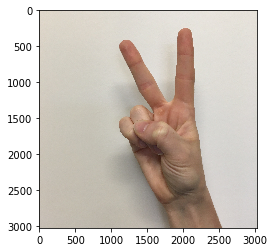

In [12]:
im_path = 'images/my_image.jpg'
im = image.load_img(im_path, target_size=(64, 64))
x = image.img_to_array(im)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(im_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

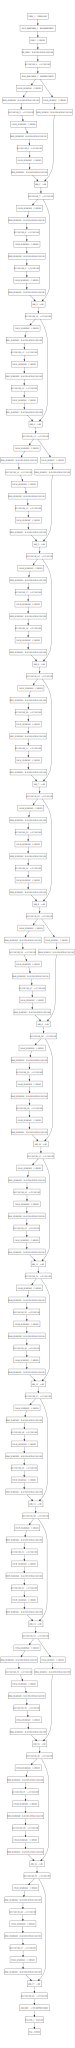

In [14]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))